In [ ]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, fbeta_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

Limpeza e correção da base cadastral

In [ ]:
base_cadastral = pd.read_csv('base_cadastral.csv')

#removendo os nan
base_cadastral['FLAG_PF'] = base_cadastral['FLAG_PF'].fillna('P')

#substituindo as letras por true ou false para melhor desempenho nos modelos
base_cadastral['FLAG_PF'] = base_cadastral['FLAG_PF'].replace({'X': True, 'P': False})

base_cadastral

<ipython-input-118-80592d221117>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_cadastral['FLAG_PF'] = base_cadastral['FLAG_PF'].replace({'X': True, 'P': False})


,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
0,1661240395903230676,2013-08-22,99,False,Serviços,YAHOO,PEQUENO,65
1,8274986328479596038,2017-01-25,31,False,Comércio,YAHOO,MEDIO,77
2,345447888460137901,2000-08-15,75,False,Serviços,HOTMAIL,PEQUENO,48
3,1003144834589372198,2017-08-06,49,False,Serviços,OUTLOOK,PEQUENO,89
4,324916756972236008,2011-02-14,88,False,Serviços,GMAIL,GRANDE,62
...,...,...,...,...,...,...,...,...
1310,3431426889924624821,2020-08-13,92,False,Serviços,HOTMAIL,MEDIO,69
1311,5288503299611498087,2020-11-03,NaN,False,Comércio,YAHOO,PEQUENO,13
1312,957773253650890560,2021-07-05,NaN,False,Comércio,GMAIL,MEDIO,20
1313,6094038865287329652,2021-07-05,NaN,False,Serviços,GMAIL,GRANDE,48


In [ ]:
# Contando a frequência de cada ID_CLIENTE
contagem_ids = base_cadastral['ID_CLIENTE'].value_counts()

# Verificando se algum id esta duplicado
duplicados = contagem_ids[contagem_ids > 1]
print(duplicados)
#nao tem duplicados
print('---')

#removendo colunas desnecessarias
base_cadastral = base_cadastral.drop(columns=['DOMINIO_EMAIL', 'DATA_CADASTRO'])

# Verificando se há algum NaN em cada coluna
print(base_cadastral.isnull().any())

Series([], Name: count, dtype: int64)
---
ID_CLIENTE             False
DDD                     True
FLAG_PF                False
SEGMENTO_INDUSTRIAL     True
PORTE                   True
CEP_2_DIG              False
dtype: bool


In [ ]:
# Corrigindo DDD usando CEP
# Dicionário de correspondência entre os dois primeiros dígitos do CEP e o DDD
cep_2dig_to_ddd = {
    '10': '11', '11': '11', '12': '12', '13': '13', '14': '14', '15': '15', '16': '16', '17': '17', '18': '18', '19': '19', #SP
    '20': '21', '21': '21', '22': '22', '23': '24', '26': '24', '27': '28',  # RJ
    '29': '27', '28': '28',  # ES
    '30': '31', '31': '31', '32': '32', '33': '33', '34': '34', '35': '35', '36': '37', '37': '37', '38': '38', '39': '38',  # MG
    '40': '71', '41': '73', '42': '73', '44': '74', '45': '75', '46': '75', '47': '75', '48': '77',  # BA
    '49': '79',  # SE
    '50': '81', '51': '81', '52': '81', '53': '81', '54': '87', '55': '87',  # PE
    '57': '82',  # AL
    '58': '83',  # PB
    '59': '84',  # RN
    '60': '85', '61': '85', '62': '85', '63': '88',  # CE
    '64': '86', '65': '89',  # PI
    '66': '91', '67': '91', '68': '94',  # PA
    '68': '96',  # AP
    '69': '92', '70': '97',  # AM
    '69': '95',  # RR
    '69': '68',  # AC
    '70': '61', '71': '61', '72': '61', '73': '61',  # DF
    '74': '62', '75': '64', '76': '64',  # GO
    '77': '63',  # TO
    '78': '65',  # MT
    '78': '69',  # RO
    '79': '67',  # MS
    '80': '41', '81': '41', '82': '42', '83': '43', '84': '44', '85': '45', '86': '46',  # PR
    '88': '48',  # SC
    '89': '49',  # SC (interior)
    '87': '44',  # PR (interior)
    '90': '51', '91': '51', '92': '53', '93': '54', '94': '55',  # RS
    '98': '99',
    '25': '22',
    '95': '95',
    '99': '99',
    '96': '96',
    '24': '24',
    '97': '55',
    '56': '87',
    '43': '43',
}

def get_ddd_from_cep_2dig(cep_2dig):
    return cep_2dig_to_ddd.get(cep_2dig, None)

# Função para corrigir o DDD com base nos dois primeiros dígitos do CEP
def corrigir_ddd(linha):
    ddd = linha['DDD']
    cep_2dig = linha['CEP_2_DIG']

    # Verifica se o DDD é NaN ou está incorreto
    if pd.isna(ddd) or ddd != get_ddd_from_cep_2dig(str(cep_2dig)):  # Verifica se o DDD é NaN corretamente
        return get_ddd_from_cep_2dig(str(cep_2dig))  # Converte CEP_2_DIG para string para garantir o mapeamento correto
    return ddd

# Percebi que em uma linha tem um cep com o valor na. Acredito que isso seja uma forma de reprsentar o cep ausente
# decidi substituir o valor na pela moda da coluna cep
moda_cep = base_cadastral['CEP_2_DIG'].mode()[0]
base_cadastral['CEP_2_DIG'].replace('na', moda_cep, inplace=True)

# Aplicar a função para corrigir os DDDs incorretos
base_cadastral['DDD'] = base_cadastral.apply(corrigir_ddd, axis=1)

<ipython-input-120-988c3906166c>:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_cadastral['CEP_2_DIG'].replace('na', moda_cep, inplace=True)


In [ ]:
# Filtrar as linhas onde a coluna 'DDD' tem valores nulos (NaN)
linhas_com_nan = base_cadastral[base_cadastral['DDD'].isnull()]

# Exibir as linhas com NaN na coluna 'DDD'
print(linhas_com_nan)

Empty DataFrame
Columns: [ID_CLIENTE, DDD, FLAG_PF, SEGMENTO_INDUSTRIAL, PORTE, CEP_2_DIG]
Index: []


In [ ]:
# Filtrar linhas onde FLAG_PF é True e SEGMENTO_INDUSTRIAL não é NaN
linhas_filtradas = base_cadastral[(base_cadastral['FLAG_PF'] == True) & (base_cadastral['SEGMENTO_INDUSTRIAL'].notnull())]

# Exibir as linhas filtradas
print(linhas_filtradas)
print('----')
#todas as entradas de PF tem o segmento industrial nulo então vou preencher esse campo um valor padrão para usar o treinamento
base_cadastral.loc[(base_cadastral['FLAG_PF'] == True) & (base_cadastral['SEGMENTO_INDUSTRIAL'].isnull()), 'SEGMENTO_INDUSTRIAL'] = 'PF'

Empty DataFrame
Columns: [ID_CLIENTE, DDD, FLAG_PF, SEGMENTO_INDUSTRIAL, PORTE, CEP_2_DIG]
Index: []
----


In [ ]:
# Filtrar as linhas onde a coluna 'DDD' tem valores nulos (NaN)
linhas_com_nan = base_cadastral[base_cadastral['SEGMENTO_INDUSTRIAL'].isnull()]
linhas_com_nan

,ID_CLIENTE,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE,CEP_2_DIG
11,3118152790263512426,22,False,NaN,MEDIO,22
19,314309872114206760,42,False,NaN,GRANDE,82
47,7818340804682162328,24,False,NaN,MEDIO,26
96,6784879562354696650,45,False,NaN,MEDIO,85
153,5574997762710520717,27,False,NaN,GRANDE,29
235,6817075905797098547,16,False,NaN,GRANDE,16
240,7810985951121711480,33,False,NaN,MEDIO,33
429,7215093571368368138,37,False,NaN,GRANDE,36
725,1687017009357941608,68,False,NaN,GRANDE,69
740,8487807876567995441,24,False,NaN,MEDIO,26


In [ ]:
# Filtrar as linhas onde a coluna 'DDD' tem valores nulos (NaN)
linhas_com_nan = base_cadastral[base_cadastral['PORTE'].isnull()]
linhas_com_nan

,ID_CLIENTE,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE,CEP_2_DIG
21,5301988619224057921,67,False,Indústria,NaN,79
51,8729164666041467296,73,False,Serviços,NaN,41
65,5761480994209806499,35,False,Comércio,NaN,35
112,7031913170099381454,77,False,Serviços,NaN,48
116,8229446069655666941,16,False,Comércio,NaN,16
170,7231408738455755015,14,False,Serviços,NaN,14
312,5988277776808227480,15,False,Comércio,NaN,15
369,1195244642827484543,32,False,Comércio,NaN,32
384,5794903898038236832,24,False,Serviços,NaN,23
402,696014079855281037,15,False,Serviços,NaN,15


In [ ]:
#separar linhas sem porte para corrigir depois
linhas_sem_porte = base_cadastral[base_cadastral['PORTE'].isna()]
linhas_com_porte = base_cadastral[base_cadastral['PORTE'].notna()]

In [ ]:
#preencher os campos NaN do segmento industrial usando a moda de cada subgrupo de porte
def fill_with_mode(group):
    moda = group['SEGMENTO_INDUSTRIAL'].mode()[0]  # Obter a moda do grupo
    group['SEGMENTO_INDUSTRIAL'].fillna(moda, inplace=True)  # Preencher NaN com a moda
    return group

# Aplicar o preenchimento para as linhas que possuem PORTE
linhas_com_porte = linhas_com_porte.groupby('PORTE').apply(fill_with_mode)

<ipython-input-126-d26d013c6bab>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  group['SEGMENTO_INDUSTRIAL'].fillna(moda, inplace=True)  # Preencher NaN com a moda
<ipython-input-126-d26d013c6bab>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

In [ ]:
linhas_com_nan = linhas_com_porte[linhas_com_porte['SEGMENTO_INDUSTRIAL'].isnull()]
print(linhas_com_nan)
#vazio quer dizer que todas linhas foram corrigidas
print('---')
# Exibir os valores únicos de 'SEGMENTO_INDUSTRIAL' nas linhas com 'PORTE'
valores_unicos_industria = linhas_com_porte['SEGMENTO_INDUSTRIAL'].unique()
valores_unicos_industria
#nenhum valor esta incorreto

Empty DataFrame
Columns: [ID_CLIENTE, DDD, FLAG_PF, SEGMENTO_INDUSTRIAL, PORTE, CEP_2_DIG]
Index: []
---


array(['Serviços', 'Indústria', 'Comércio', 'PF'], dtype=object)

In [ ]:
#corrigir o campo de porte usando a mesma logica de agrupar por industria e pegar a moda
# Função para preencher valores NaN com a moda dentro de cada grupo de SEGMENTO_INDUSTRIAL
def fill_porte_with_mode(group):
    moda = group['PORTE'].mode()[0]  # Obter a moda do grupo
    group['PORTE'].fillna(moda, inplace=True)  # Preencher NaN com a moda
    return group

#caso existam valores nulos em segmento industrial então é possível aplicar a logica de moda agrupada pois porte é nulo tbm. Aplicar a moda simples
moda_industria = linhas_sem_porte['SEGMENTO_INDUSTRIAL'].mode()[0]
# Preencher os valores NaN na coluna SEGMENTO_INDUSTRIAL com a moda geral
linhas_sem_porte['SEGMENTO_INDUSTRIAL'].fillna(moda_industria, inplace=True)

# Concatenar 'linhas_com_porte' e 'linhas_sem_porte' para fazer a moda e preencher os campos de PORTE
base_cadastral = pd.concat([linhas_com_porte, linhas_sem_porte], ignore_index=True)

# Aplicar o preenchimento de moda para cada grupo de SEGMENTO_INDUSTRIAL nas linhas com 'PORTE' e 'SEGMENTO_INDUSTRIAL'
base_cadastral = base_cadastral.groupby('SEGMENTO_INDUSTRIAL', group_keys=False).apply(fill_porte_with_mode)
valores_unicos_porte = base_cadastral['PORTE'].unique()
valores_unicos_porte
#nenhum valor esta incorreto

<ipython-input-128-54fb93a71a98>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  linhas_sem_porte['SEGMENTO_INDUSTRIAL'].fillna(moda_industria, inplace=True)
<ipython-input-128-54fb93a71a98>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linhas_sem_porte['SEGMENTO_INDUSTRIAL'].fillna(moda_industria, inplace=True)
<ipython-input-128-54fb93

array(['GRANDE', 'MEDIO', 'PEQUENO'], dtype=object)

In [ ]:
# Verificando se há algum NaN em cada coluna
print(base_cadastral.isnull().any())

ID_CLIENTE             False
DDD                    False
FLAG_PF                False
SEGMENTO_INDUSTRIAL    False
PORTE                  False
CEP_2_DIG              False
dtype: bool


In [ ]:
base_cadastral

,ID_CLIENTE,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE,CEP_2_DIG
0,324916756972236008,85,False,Serviços,GRANDE,62
1,4679462479444735708,19,False,Indústria,GRANDE,19
2,3668905663669864663,44,False,Comércio,GRANDE,87
3,7041489327620930099,37,False,Serviços,GRANDE,37
4,1366416810235233769,13,False,Comércio,GRANDE,13
...,...,...,...,...,...,...
1310,2648719990986789645,69,True,PF,GRANDE,78
1311,8222831719332844924,18,False,Serviços,MEDIO,18
1312,1246864346193559124,43,False,Indústria,MEDIO,83
1313,2386535178006664233,61,True,PF,GRANDE,71


Limpeza e correção da base cadastral concluida

Limpeza e correção da base info

In [ ]:
base_info = pd.read_csv('base_info.csv')
base_info

,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-09,16913.0,92.0
1,8274986328479596038,2018-09,106430.0,141.0
2,345447888460137901,2018-09,707439.0,99.0
3,1003144834589372198,2018-09,239659.0,96.0
4,324916756972236008,2018-09,203123.0,103.0
...,...,...,...,...
24396,705648002974742140,2021-12,278663.0,105.0
24397,4993499380140734678,2021-12,156968.0,140.0
24398,4614484019183480654,2021-12,292698.0,121.0
24399,1299146298565441811,2021-12,106180.0,121.0


In [ ]:
# Verificar se há valores nulos na coluna 'RENDA_MES_ANTERIOR'
valores_nulos_renda = base_info['RENDA_MES_ANTERIOR'].isnull().any()
print(f"Há valores nulos em 'RENDA_MES_ANTERIOR'? {valores_nulos_renda}")

# Verificar se há valores negativos na coluna 'RENDA_MES_ANTERIOR'
valores_negativos_renda = (base_info['RENDA_MES_ANTERIOR'] < 0).any()
print(f"Há valores negativos em 'RENDA_MES_ANTERIOR'? {valores_negativos_renda}")

Há valores nulos em 'RENDA_MES_ANTERIOR'? False
Há valores negativos em 'RENDA_MES_ANTERIOR'? False


In [ ]:
# Tentar converter a coluna 'SAFRA_REF' para datetime
# Erros serão convertidos para NaT (Not a Time)
base_info['SAFRA_REF'] = pd.to_datetime(base_info['SAFRA_REF'], errors='coerce', format='%Y-%m')

# Verificar se há valores NaT, que indicam datas com formato incorreto
datas_invalidas = base_info[base_info['SAFRA_REF'].isna()]

# Exibir as linhas com datas inválidas
if not datas_invalidas.empty:
    print("Linhas com datas inválidas:")
    print(datas_invalidas)
else:
    print("Todas as datas estão corretamente formatadas.")

Todas as datas estão corretamente formatadas.


In [ ]:
# Verificar se há valores nulos na coluna 'NO_FUNCIONARIOS'
valores_nulos_funcionarios = base_info['NO_FUNCIONARIOS'].isnull().any()
print(f"Há valores nulos em 'NO_FUNCIONARIOS'? {valores_nulos_funcionarios}")

# Verificar se há valores negativos na coluna 'NO_FUNCIONARIOS'
valores_negativos_funcionarios = (base_info['NO_FUNCIONARIOS'] < 0).any()
print(f"Há valores negativos em 'NO_FUNCIONARIOS'? {valores_negativos_funcionarios}")

Há valores nulos em 'NO_FUNCIONARIOS'? False
Há valores negativos em 'NO_FUNCIONARIOS'? False


In [ ]:
# Verificar se existem linhas duplicadas no DataFrame
linhas_duplicadas = base_info[base_info.duplicated()]

# Exibir as linhas duplicadas, se existirem
if not linhas_duplicadas.empty:
    print("Linhas duplicadas encontradas:")
    print(linhas_duplicadas)
else:
    print("Nenhuma linha duplicada encontrada.")

Nenhuma linha duplicada encontrada.


base info verificada

Analise e correção de base pagamentos desenvolvimento

In [ ]:
base_pagamentos_desenvolvimento = pd.read_csv('base_pagamentos_desenvolvimento.csv')
base_pagamentos_desenvolvimento

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99
...,...,...,...,...,...,...,...
77409,2951563549197799278,2021-06,2021-06-30,2021-07-16,2021-07-16,89980.00,5.99
77410,5220206408301580591,2021-06,2021-06-30,2021-08-16,2021-08-16,42239.00,5.99
77411,5860276371789140450,2021-06,2021-06-30,2021-07-16,2021-07-16,20921.50,5.99
77412,2814790209436551216,2021-06,2021-06-30,2021-07-16,2021-07-16,90231.05,6.99


In [ ]:
def verificar_duplicatas(dataset):
  #remover linhas duplicadas
  dataset = dataset.drop_duplicates()
  print("\nLinhas duplicadas removidas (caso existam).")
  return dataset

In [ ]:
def verificar_nulos(dataset):
  # Verificar se há valores nulos em cada coluna
  valores_nulos = dataset.isnull().any()
  print("Colunas com valores nulos:")
  print(valores_nulos[valores_nulos == True])

In [ ]:
def verificar_datas(dataset):
  # Verificar se as datas estão no formato datetime, caso contrário, converter
  dataset['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(dataset['DATA_EMISSAO_DOCUMENTO'], errors='coerce')
  dataset['DATA_VENCIMENTO'] = pd.to_datetime(dataset['DATA_VENCIMENTO'], errors='coerce')
  #verificar se data pagamento existe pois é exclusivo do treino
  if 'DATA_PAGAMENTO' in dataset.columns:
    dataset['DATA_PAGAMENTO'] = pd.to_datetime(dataset['DATA_PAGAMENTO'], errors='coerce')

  verificar_nulos(dataset)

  # Verificar se DATA_EMISSAO_DOCUMENTO é posterior à DATA_VENCIMENTO (não deveria ser)
  datas_emissao_invalidas = dataset[dataset['DATA_EMISSAO_DOCUMENTO'] > dataset['DATA_VENCIMENTO']]
  if not datas_emissao_invalidas.empty:
      print("\nTem linhas com a DATA_EMISSAO_DOCUMENTO posterior à DATA_VENCIMENTO (erro)")
      #remover linhas com datas_emissao_invalidas de base_pagamentos
      dataset = dataset.drop(datas_emissao_invalidas.index)

      print("\nLinhas inválidas removidas.")
  else:
      print("\nNenhuma linha com DATA_EMISSAO_DOCUMENTO posterior à DATA_VENCIMENTO.")
  return dataset

In [ ]:
def valor_pagar_positivo(dataset):
  # Verificar se 'VALOR_A_PAGAR' tem valores negativos (não deveria ter)
  valores_negativos_valor = dataset[dataset['VALOR_A_PAGAR'] < 0]
  if not valores_negativos_valor.empty:
      print("\nLinhas com VALOR_A_PAGAR negativo:")
      print(valores_negativos_valor)
  else:
      print("\nTodos os valores de 'VALOR_A_PAGAR' são positivos.")

In [ ]:
def taxa_positiva(dataset):
  # Verificar se 'TAXA' tem valores negativos ou não numéricos
  valores_invalidos_taxa = dataset[dataset['TAXA'] < 0]
  if not valores_invalidos_taxa.empty:
      print("\nLinhas com TAXA negativa:")
      print(valores_invalidos_taxa)
  else:
      print("\nTodos os valores de 'TAXA' são positivos.")

In [ ]:
def verificar_inadimplete(dataset):
  # Verificar se a coluna 'inadimplente' contém apenas valores binários (0 ou 1)
  valores_invalidos_inadimplente = base_pagamentos_desenvolvimento[~base_pagamentos_desenvolvimento['inadimplente'].isin([0, 1])]
  if not valores_invalidos_inadimplente.empty:
      print("\nLinhas com valores inválidos em 'inadimplente' (não 0 ou 1):")
      print(valores_invalidos_inadimplente)
  else:
      print("\nTodos os valores de 'inadimplente' são binários (0 ou 1).")

In [ ]:
def verificar_prazo_pagamento(dataset):
  # Verificar se a coluna 'prazo_pagamento' contém valores negativos (não deveria ter)
  valores_negativos_prazo = base_pagamentos_desenvolvimento[base_pagamentos_desenvolvimento['prazo_pagamento'] < 0]
  if not valores_negativos_prazo.empty:
      print("\nLinhas com 'prazo_pagamento' negativo:")
      print(valores_negativos_prazo)
  else:
      print("\nTodos os valores de 'prazo_pagamento' são positivos")

In [ ]:
verificar_nulos(base_pagamentos_desenvolvimento)
data_pagamentos_desenvolvimento = verificar_duplicatas(base_pagamentos_desenvolvimento)
base_pagamentos_desenvolvimento = verificar_datas(base_pagamentos_desenvolvimento)
valor_pagar_positivo(base_pagamentos_desenvolvimento)
taxa_positiva(base_pagamentos_desenvolvimento)

Colunas com valores nulos:
Series([], dtype: bool)

Linhas duplicadas removidas (caso existam).
Colunas com valores nulos:
Series([], dtype: bool)

Tem linhas com a DATA_EMISSAO_DOCUMENTO posterior à DATA_VENCIMENTO (erro)

Linhas inválidas removidas.

Todos os valores de 'VALOR_A_PAGAR' são positivos.

Todos os valores de 'TAXA' são positivos.


In [ ]:
# Converte as datas em datetime pra poder fazer a diferença mais facilmente depois
base_pagamentos_desenvolvimento['DATA_PAGAMENTO'] = pd.to_datetime(base_pagamentos_desenvolvimento['DATA_PAGAMENTO'])
base_pagamentos_desenvolvimento['DATA_VENCIMENTO'] = pd.to_datetime(base_pagamentos_desenvolvimento['DATA_VENCIMENTO'])
base_pagamentos_desenvolvimento['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(base_pagamentos_desenvolvimento['DATA_EMISSAO_DOCUMENTO'])

# Calcular atraso no pagamento
base_pagamentos_desenvolvimento['atraso'] = base_pagamentos_desenvolvimento['DATA_PAGAMENTO'] - base_pagamentos_desenvolvimento['DATA_VENCIMENTO']

# criar a variavel inadimplente para treinar o modelo
base_pagamentos_desenvolvimento['inadimplente'] = (base_pagamentos_desenvolvimento['atraso'].dt.days >= 5).astype(int)

# Calcular a diferença entre as duas datas em dias e criar a coluna 'prazo_pagamento'
base_pagamentos_desenvolvimento['prazo_pagamento'] = (base_pagamentos_desenvolvimento['DATA_VENCIMENTO'] - base_pagamentos_desenvolvimento['DATA_EMISSAO_DOCUMENTO']).dt.days

# Remover as colunas 'DATA_VENCIMENTO', 'DATA_EMISSAO_DOCUMENTO' e 'DATA_PAGAMENTO'
base_pagamentos_desenvolvimento.drop(columns=['DATA_VENCIMENTO', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO', 'atraso'], inplace=True)

In [ ]:
verificar_inadimplete(base_pagamentos_desenvolvimento)
verificar_prazo_pagamento(base_pagamentos_desenvolvimento)


Todos os valores de 'inadimplente' são binários (0 ou 1).

Todos os valores de 'prazo_pagamento' são positivos


In [ ]:
base_pagamentos_desenvolvimento

,ID_CLIENTE,SAFRA_REF,VALOR_A_PAGAR,TAXA,inadimplente,prazo_pagamento
0,1661240395903230676,2018-08,35516.41,6.99,0,20
1,1661240395903230676,2018-08,17758.21,6.99,0,22
2,1661240395903230676,2018-08,17431.96,6.99,0,22
3,1661240395903230676,2018-08,1341.00,6.99,1,36
4,1661240395903230676,2018-08,21309.85,6.99,0,20
...,...,...,...,...,...,...
77409,2951563549197799278,2021-06,89980.00,5.99,0,16
77410,5220206408301580591,2021-06,42239.00,5.99,0,47
77411,5860276371789140450,2021-06,20921.50,5.99,0,16
77412,2814790209436551216,2021-06,90231.05,6.99,0,16


Limpeza e correção da base pagamentos desenvolvimento completada

Analise dos dados de teste

In [ ]:
base_pagamentos_teste = pd.read_csv('base_pagamentos_teste.csv')
base_pagamentos_teste

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99
...,...,...,...,...,...,...
12270,705648002974742140,2021-11,2021-11-25,2021-12-13,47010.00,6.99
12271,4993499380140734678,2021-11,2021-11-25,2021-12-13,122875.35,8.99
12272,4614484019183480654,2021-11,2021-11-26,2028-09-30,302200.00,5.99
12273,1299146298565441811,2021-11,2021-11-26,2021-12-13,143791.85,5.99


In [ ]:
verificar_nulos(base_pagamentos_teste)
data_pagamentos_teste = verificar_duplicatas(base_pagamentos_teste)
base_pagamentos_teste = verificar_datas(base_pagamentos_teste)
valor_pagar_positivo(base_pagamentos_teste)
taxa_positiva(base_pagamentos_teste)

Colunas com valores nulos:
Series([], dtype: bool)

Linhas duplicadas removidas (caso existam).
Colunas com valores nulos:
Series([], dtype: bool)

Tem linhas com a DATA_EMISSAO_DOCUMENTO posterior à DATA_VENCIMENTO (erro)

Linhas inválidas removidas.

Todos os valores de 'VALOR_A_PAGAR' são positivos.

Todos os valores de 'TAXA' são positivos.


In [ ]:
# Converte as datas em datetime pra poder fazer a diferença mais facilmente depois
base_pagamentos_teste['DATA_VENCIMENTO'] = pd.to_datetime(base_pagamentos_teste['DATA_VENCIMENTO'])
base_pagamentos_teste['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(base_pagamentos_teste['DATA_EMISSAO_DOCUMENTO'])

# Calcular a diferença entre as duas datas em dias e criar a coluna 'prazo_pagamento'
base_pagamentos_teste['prazo_pagamento'] = (base_pagamentos_teste['DATA_VENCIMENTO'] - base_pagamentos_teste['DATA_EMISSAO_DOCUMENTO']).dt.days

# Remover as colunas 'DATA_VENCIMENTO', 'DATA_EMISSAO_DOCUMENTO' e 'DATA_PAGAMENTO'
base_pagamentos_teste.drop(columns=['DATA_VENCIMENTO', 'DATA_EMISSAO_DOCUMENTO'], inplace=True)

In [ ]:
verificar_prazo_pagamento(base_pagamentos_teste)


Todos os valores de 'prazo_pagamento' são positivos


In [ ]:
base_pagamentos_teste

,ID_CLIENTE,SAFRA_REF,VALOR_A_PAGAR,TAXA,prazo_pagamento
0,5058298901476893676,2021-07,11204.75,4.99,21
1,274692171162531764,2021-07,60718.50,5.99,46
2,274692171162531764,2021-07,60718.50,5.99,45
3,274692171162531764,2021-07,62250.00,5.99,45
4,465309249432033993,2021-07,26593.95,6.99,25
...,...,...,...,...,...
12270,705648002974742140,2021-11,47010.00,6.99,18
12271,4993499380140734678,2021-11,122875.35,8.99,18
12272,4614484019183480654,2021-11,302200.00,5.99,2500
12273,1299146298565441811,2021-11,143791.85,5.99,17


Concluida limpeza dos dados de testes

Montar (join) os dados de treino e teste

In [ ]:
#estava tendo um erro que SAFRA_REF tinha tipos diferentes em base info e base pagamentos
#então colocar todas como datetime
base_info['SAFRA_REF'] = pd.to_datetime(base_info['SAFRA_REF'], errors='coerce')
base_pagamentos_desenvolvimento['SAFRA_REF'] = pd.to_datetime(base_pagamentos_desenvolvimento['SAFRA_REF'], errors='coerce')
base_pagamentos_teste['SAFRA_REF'] = pd.to_datetime(base_pagamentos_teste['SAFRA_REF'], errors='coerce')

In [ ]:
'''
Percebi o problema que estava dando NaN nos joins. Após analise eu acho que entendi o problema.
O base_info tem dados de 2018-9 até 2021-12
base pagamentos de treino tem dados de 2018-8 até 2021-6
base pagamentos de teste tem dados de 2021-7 até 2021-11
Isso acontece por que o base_info de 2018-9 tem os campos renda e numero de funcionários do mês anterior, ou seja, de 2018-8.
Por isso na hora de fazer o merge eu devo diminuir o mês em base_info em 1
'''
base_info['SAFRA_REF'] = pd.to_datetime(base_info['SAFRA_REF'], errors='coerce')  # Certificar que SAFRA_REF é datetime
base_info['SAFRA_REF'] = base_info['SAFRA_REF'] - DateOffset(months=1)  # Subtrair 1 mês

In [ ]:
# Primeiro join: Juntar 'base_info' com 'base_cadastral' usando 'ID_CLIENTE'
merge1 = pd.merge(base_info, base_cadastral, on='ID_CLIENTE', how='left')

#resolve os casos que percebi que id de clientes em base info não tinham entrada em base cadastral
merge1 = merge1.dropna()

# Segundo join: Juntar 'base_pagamentos' com o resultado anterior, usando 'ID_CLIENTE' e 'SAFRA_REF' para criar o dataset de treino
dataset_treino = pd.merge(base_pagamentos_desenvolvimento, merge1, on=['ID_CLIENTE', 'SAFRA_REF'], how='left')
dataset_treino = dataset_treino.dropna()

# repetir o processo para criar o dataset de teste
dataset_teste = pd.merge(base_pagamentos_teste, merge1, on=['ID_CLIENTE', 'SAFRA_REF'], how='left')
dataset_teste = dataset_teste.dropna()

In [ ]:
dataset_treino

,ID_CLIENTE,SAFRA_REF,VALOR_A_PAGAR,TAXA,inadimplente,prazo_pagamento,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE,CEP_2_DIG
0,1661240395903230676,2018-08-01,35516.41,6.99,0,20,16913.0,92.0,89,False,Serviços,PEQUENO,65
1,1661240395903230676,2018-08-01,17758.21,6.99,0,22,16913.0,92.0,89,False,Serviços,PEQUENO,65
2,1661240395903230676,2018-08-01,17431.96,6.99,0,22,16913.0,92.0,89,False,Serviços,PEQUENO,65
3,1661240395903230676,2018-08-01,1341.00,6.99,1,36,16913.0,92.0,89,False,Serviços,PEQUENO,65
4,1661240395903230676,2018-08-01,21309.85,6.99,0,20,16913.0,92.0,89,False,Serviços,PEQUENO,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77382,2951563549197799278,2021-06-01,89980.00,5.99,0,16,463343.0,161.0,13,False,Comércio,PEQUENO,13
77383,5220206408301580591,2021-06-01,42239.00,5.99,0,47,549222.0,92.0,22,False,Indústria,GRANDE,25
77384,5860276371789140450,2021-06-01,20921.50,5.99,0,16,151832.0,120.0,91,False,Serviços,GRANDE,67
77385,2814790209436551216,2021-06-01,90231.05,6.99,0,16,24792.0,107.0,14,False,Serviços,MEDIO,14


In [ ]:
dataset_teste

,ID_CLIENTE,SAFRA_REF,VALOR_A_PAGAR,TAXA,prazo_pagamento,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE,CEP_2_DIG
0,5058298901476893676,2021-07-01,11204.75,4.99,21,473286.0,145.0,99,False,Serviços,MEDIO,99
1,274692171162531764,2021-07-01,60718.50,5.99,46,472530.0,109.0,13,False,Serviços,PEQUENO,13
2,274692171162531764,2021-07-01,60718.50,5.99,45,472530.0,109.0,13,False,Serviços,PEQUENO,13
3,274692171162531764,2021-07-01,62250.00,5.99,45,472530.0,109.0,13,False,Serviços,PEQUENO,13
4,465309249432033993,2021-07-01,26593.95,6.99,25,324549.0,111.0,64,False,Comércio,GRANDE,76
...,...,...,...,...,...,...,...,...,...,...,...,...
12268,705648002974742140,2021-11-01,47010.00,6.99,18,278663.0,105.0,67,False,Indústria,MEDIO,79
12269,4993499380140734678,2021-11-01,122875.35,8.99,18,156968.0,140.0,37,False,Serviços,PEQUENO,37
12270,4614484019183480654,2021-11-01,302200.00,5.99,2500,292698.0,121.0,54,False,Indústria,MEDIO,93
12271,1299146298565441811,2021-11-01,143791.85,5.99,17,106180.0,121.0,21,False,Serviços,MEDIO,21


Datasets de treino e teste construidos

Treinamento da rede neural

In [ ]:
# Remover as colunas 'ID_CLIENTE' e 'SAFRA_REF' do dataset por que identificares individuais e eu quero uma rede que generaliza
dataset_treino = dataset_treino.drop(['ID_CLIENTE', 'SAFRA_REF'], axis=1)

In [ ]:
categorical_columns = ['FLAG_PF', 'SEGMENTO_INDUSTRIAL', 'DDD', 'CEP_2_DIG', 'PORTE']

# Inicializar o OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar o encoder no conjunto de treino e transformar
encoded_train = encoder.fit_transform(dataset_treino[categorical_columns])

# Criar um DataFrame com os dados codificados
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))

# Resetar os índices dos DataFrames antes da concatenação por que isso estava fazendo ele criar linhas que não deveriam existir
dataset_treino = dataset_treino.reset_index(drop=True)
encoded_train_df = encoded_train_df.reset_index(drop=True)

# Concatenar os dados codificados com o dataset original, removendo as colunas categóricas
dataset_treino = pd.concat([dataset_treino.drop(columns=categorical_columns), encoded_train_df], axis=1)

In [ ]:
# Definir as colunas numéricas
numeric_features = ['VALOR_A_PAGAR', 'TAXA', 'prazo_pagamento', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']

# Inicializar o StandardScaler
scaler = StandardScaler()

# Aplicar o scaler às colunas numéricas
dataset_treino[numeric_features] = scaler.fit_transform(dataset_treino[numeric_features])

In [ ]:
# Separar a variável target
X = dataset_treino.drop('inadimplente', axis=1)
y = dataset_treino['inadimplente']

# 1. Dividir os dados em treino/validação e teste (90% treino/validação, 10% teste)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# 2. Dividir os dados de treino/validação em treino e validação (80% treino, 20% validação)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=42, stratify=y_train_val)
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (53500, 162)
X_val shape: (13375, 162)
X_test shape: (7431, 162)


In [ ]:
'''
na primeira versão essa era a matriz de confusão. O recall estava em 58%. Decidi aplicar um peso maior a classe 1, pois ela tem um
um número muito menor de amostras, então acaba tendo menos impacto na redução do erro da rede.
Matriz de Confusão da primeira versão:
[[6773  152]
 [ 210  296]]
'''
# Definir as classes (0: não inadimplente, 1: inadimplente)
classes = np.unique(y_train)
# Calcular os pesos das classes
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Converter para um dicionário, que o Keras espera
class_weight_dict = dict(enumerate(class_weights))

print(f"Pesos das classes: {class_weight_dict}")

Pesos das classes: {0: 0.5365129665657153, 1: 7.346882724526229}


In [ ]:
# Definir o espaço de hiperparâmetros
space = {
    'neurons': hp.choice('neurons', [32, 64, 128]),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.6),  # Intervalo contínuo com hp.uniform
    'l2_value': hp.loguniform('l2_value', -4, -1),  # Valores entre 0.0001 e 0.1
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop']),  # Escolha entre otimizadores
    'epochs': hp.quniform('epochs', 30, 100, 10),
    'batch_size': hp.quniform('batch_size', 32, 128, 32)
}

In [ ]:
num_features = X_train.shape[1]  # Número de colunas no dataset de treino

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Função para construir o modelo
def build_model(params):
    model = Sequential()

    # Camada de entrada e primeira camada oculta
    model.add(Dense(params['neurons'], input_dim=num_features, activation='relu', kernel_regularizer=l2(params['l2_value'])))
    model.add(Dropout(params['dropout_rate']))

    # Segunda camada oculta
    model.add(Dense(params['neurons'] * 2, activation='relu', kernel_regularizer=l2(params['l2_value'])))
    model.add(Dropout(params['dropout_rate']))

    # Terceira camada oculta
    model.add(Dense(params['neurons'], activation='relu', kernel_regularizer=l2(params['l2_value'])))
    model.add(Dropout(params['dropout_rate']))

    # Camada de saída
    model.add(Dense(1, activation='sigmoid'))

    # Compilar o modelo
    if params['optimizer'] == 'adam':
        opt = Adam()
    else:
        opt = RMSprop()

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

    return model

In [ ]:
# Função de objetivo para o Hyperopt
def objective(params):
    model = build_model(params)

    # Treinar o modelo
    model.fit(X_train, y_train.values.ravel(),
              epochs=int(params['epochs']),
              batch_size=int(params['batch_size']),
              callbacks=[early_stopping],
              validation_data=(X_val, y_val.values.ravel()),
              class_weight=class_weight_dict,
              verbose=0)

    # Fazer previsões no conjunto de validação
    y_pred = (model.predict(X_val) > 0.5).astype(int)

    # Calcular o F-beta Score, onde beta > 1 dá mais peso ao recall
    beta = 2
    fbeta = fbeta_score(y_val, y_pred, beta=beta)

    # Poe a metrica negativa por ser uma função de minimização
    return {'loss': -fbeta, 'status': STATUS_OK}

In [ ]:
# Executar o Hyperopt
'''trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

best_params = {
    'optimizer': ['adam', 'rmsprop'][best['optimizer']],  # Mapeando o índice para o nome do otimizador
    'dropout_rate': best['dropout_rate'],
    'neurons': [32, 64, 128][best['neurons']],
    'l2_value': best['l2_value'],
    'epochs': int(best['epochs']),  # hp.quniform retorna float, então converta para int
    'batch_size': int(best['batch_size'])
}'''
#eu experimentei usar hyperopt para busca de hiperarametros,
#mas os resultados ficaram proximos ou piores dos parametros aplicados manualmente
#deixei aqui para caso pretende aprimorar essa etapa no futuro para que faça sentido usar

"trials = Trials()\nbest = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)\n\nbest_params = {\n    'optimizer': ['adam', 'rmsprop'][best['optimizer']],  # Mapeando o índice para o nome do otimizador\n    'dropout_rate': best['dropout_rate'],\n    'neurons': [32, 64, 128][best['neurons']],\n    'l2_value': best['l2_value'],\n    'epochs': int(best['epochs']),  # hp.quniform retorna float, então converta para int\n    'batch_size': int(best['batch_size'])\n}"

In [ ]:
# caso queira usar o hyperot então comecente esse best_params abaixo e descomente o de cima
best_params = {
    'optimizer': 'adam',
    'dropout_rate': 0.2,
    'neurons': 64,
    'l2_value': 0.0001,
    'epochs': 50,
    'batch_size': 32
}
model = build_model(best_params)

# Treinar o modelo e salvar o histórico
history = model.fit(
    X_train, y_train.values.ravel(),
    validation_data=(X_val, y_val.values.ravel()),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - Recall: 0.7243 - accuracy: 0.7152 - loss: 0.5815 - val_Recall: 0.8143 - val_accuracy: 0.8256 - val_loss: 0.4035
Epoch 2/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - Recall: 0.8206 - accuracy: 0.8180 - loss: 0.4510 - val_Recall: 0.8352 - val_accuracy: 0.8515 - val_loss: 0.4100
Epoch 3/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.8401 - accuracy: 0.8445 - loss: 0.4052 - val_Recall: 0.8429 - val_accuracy: 0.8571 - val_loss: 0.3728
Epoch 4/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - Recall: 0.8527 - accuracy: 0.8394 - loss: 0.3984 - val_Recall: 0.8692 - val_accuracy: 0.8394 - val_loss: 0.4156
Epoch 5/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - Recall: 0.8695 - accuracy: 0.8482 - loss: 0.3828 - val_Recall: 0.8176 - val_accuracy: 0.8852 - val_loss: 0.3254
Epoch 6/50
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - Recall: 0.8756 - accuracy: 0.8562 - loss: 0.3633 - val_Recall: 0.8846 - val_accuracy: 0.8475 - val_loss

In [ ]:
# Avaliar o modelo no conjunto de validação
val_loss, val_accuracy, val_recall = model.evaluate(X_val, y_val.values.ravel())
print(f'Loss no conjunto de validação: {val_loss}')
print(f'Acurácia no conjunto de validação: {val_accuracy}')
print(f'Recall no conjunto de validação: {val_recall}')

418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Recall: 0.7946 - accuracy: 0.8848 - loss: 0.3277
Loss no conjunto de validação: 0.325382798910141
Acurácia no conjunto de validação: 0.8852336406707764
Recall no conjunto de validação: 0.8175824284553528


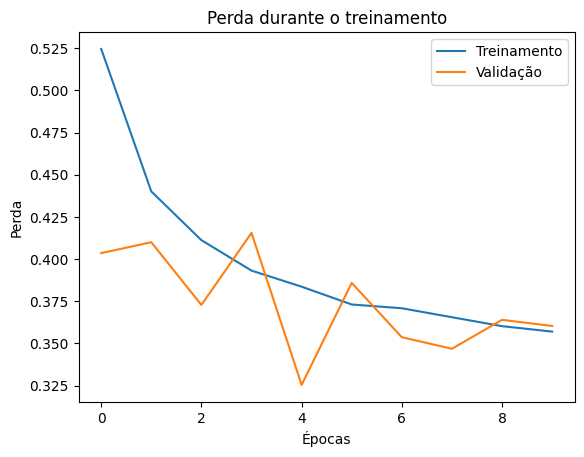

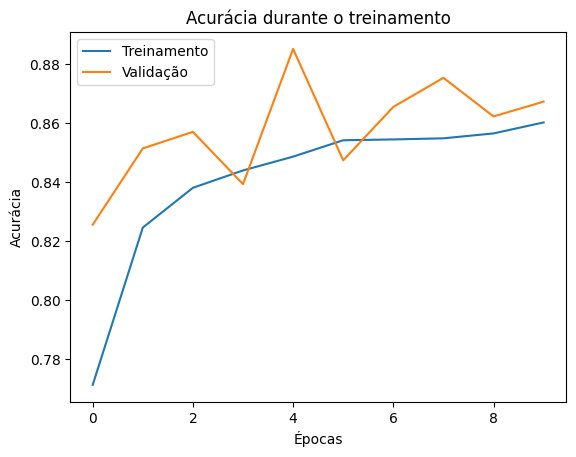

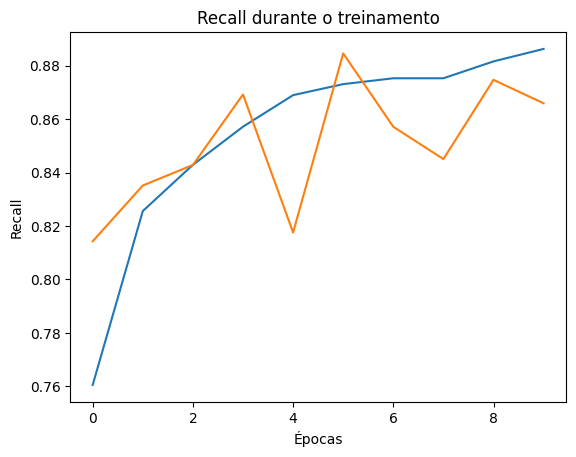

In [ ]:
# Plotar a perda (loss)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Plotar a acurácia (accuracy)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Plotar o Recall
plt.plot(history.history['Recall'], label='Treinamento')
plt.plot(history.history['val_Recall'], label='Validação')
plt.title('Recall durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.show()

In [ ]:
#mostrar a matriz de confusão para verificar os falsos negativos
y_pred_prob = model.predict(X_test)

# Converter as probabilidades em rótulos binários usando um threshold de 0.5
y_pred = (y_pred_prob >= 0.7).astype(int)

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão
print("Matriz de Confusão:")
print(cm)

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Matriz de Confusão:
[[6428  497]
 [ 125  381]]


In [ ]:
y_pred_prob = model.predict(X_test).ravel()  # Achatar para 1D

y_pred = (y_pred_prob >= 0.5).astype(int)

# Calcular Recall
recall = recall_score(y_test, y_pred)

# Calcular Acurácia
accuracy = accuracy_score(y_test, y_pred)

# Calcular a perda (loss) - usando a mesma função de perda usada no treinamento
loss = tf.keras.losses.binary_crossentropy(y_test.values.ravel(), y_pred_prob)

# Calcular o F1-Score
f1 = f1_score(y_test, y_pred)

# Calcular a precisão
precision = precision_score(y_test, y_pred)


# Exibir os resultados
print(f"Recall: {recall:.2f}")
print(f"Acurácia: {accuracy:.2f}")
print(f"Perda (Loss): {loss.numpy().mean():.4f}")
print(f"F1-Score: {f1:.2f}")
print(f"Precisão: {precision:.2f}")

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Recall: 0.82
Acurácia: 0.88
Perda (Loss): 0.2937
F1-Score: 0.49
Precisão: 0.35


Minha interpretação dos resultados:

Após adicionar pesos as classes o recall melhorou significativamente. Ele esta conseguindo identificar 82% dos inadimplentes. Por outro lado a precisão diminuiu chegando a 35%. Isso significa que das previsões em
que ele disse ser inadimplente, 35% eram corretas. Mesmo assim a acurácia ainda é alta, 88%. Como podemos ver na matriz de
confusão das 6925 amostras que não eram inadimplementes, ele acertou como 'não inadimplentes' 6428.

O F1-Score de 0.49 reflete um equilíbrio entre a precisão e o recall. Como o F1-Score está significativamente mais próximo do recall
do que da precisão, isso indica que o modelo está mais focado em capturar inadimplentes (bom recall), e por isso está sacrificando a
qualidade das previsões positivas (precisão).

O modelo está focando em capturar a maior parte dos inadimplentes (alto recall), mesmo que isso signifique prever erroneamente que
alguns clientes são inadimplentes quando, na verdade, não são (baixa precisão). Isso sugere que o modelo está arriscando mais no sentido
de capturar o máximo de inadimplentes possível, mas comete erros ao prever inadimplência em clientes que não são inadimplentes.

O modelo sempre pode ser ajustado de acordo com a vontade por meio de metricas customizadas. Eu ao construir o modelo imaginei que fosse uma
prioridade maior evitar possíveis emprestimos a inadimplemtes, por isso modifiquei as metricas para focar mais no recall.

Por meio de tecnicas de dropout eu consegui reduzir significamente o número de não inadimplentes que passaram despercebidos, chegando a 89 no menor número, mas isso resultou no aumento de não inadimplentes classificados como inadimplentes, chegando a mais de 800. Optei por reduzir a dropout pois a melhoria do recall estava trazendo uma perca muito grande na precisão.

Fazer as previsões finais para avaliação

In [ ]:
# Aplicar o encoder do treinamento no conjunto de teste
encoded_test = encoder.transform(dataset_teste[categorical_columns])

# Criar um DataFrame com os dados codificados para o teste
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

# Resetar os índices dos DataFrames antes da concatenação por que isso estava fazendo ele criar linhas que não deveriam existir
dataset_teste = dataset_teste.reset_index(drop=True)
encoded_test_df = encoded_test_df.reset_index(drop=True)

# Concatenar os dados codificados com o dataset de teste original, removendo as colunas categóricas
dataset_teste = pd.concat([dataset_teste.drop(columns=categorical_columns), encoded_test_df], axis=1)

In [ ]:
# Aplicar o scaler do treinamento ao conjunto de teste
dataset_teste[numeric_features] = scaler.transform(dataset_teste[numeric_features])

In [ ]:
#fazer a predição usando todas as colunas exceto id_cliente e safra_ref
X_teste = dataset_teste.drop(columns=['ID_CLIENTE', 'SAFRA_REF'])

y_pred_final = model.predict(X_teste)
resultado_final = dataset_teste[['ID_CLIENTE', 'SAFRA_REF']].copy()  # Criar o resultado final
resultado_final['INADIMPLENTE'] = y_pred_final                       # Adicionar a previsão

resultado_final.to_csv('resultado_final.csv', index=False)

# Exibir o resultado final
# Definir um limiar para considerar previsões mais próximas de 0 ou 1 (0.5 é o valor padrão para classificação binária)
threshold = 0.5

# Contar previsões mais próximas de 0
proximas_de_0 = (resultado_final['INADIMPLENTE'] < threshold).sum()

# Contar previsões mais próximas de 1
proximas_de_1 = (resultado_final['INADIMPLENTE'] >= threshold).sum()

# Exibir os resultados
print(f"Previsões mais próximas de 0: {proximas_de_0}")
print(f"Previsões mais próximas de 1: {proximas_de_1}")
resultado_final

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Previsões mais próximas de 0: 9965
Previsões mais próximas de 1: 1245


,ID_CLIENTE,SAFRA_REF,INADIMPLENTE
0,5058298901476893676,2021-07-01,0.013718
1,274692171162531764,2021-07-01,0.101212
2,274692171162531764,2021-07-01,0.096825
3,274692171162531764,2021-07-01,0.096529
4,465309249432033993,2021-07-01,0.069538
...,...,...,...
11205,705648002974742140,2021-11-01,0.818087
11206,4993499380140734678,2021-11-01,0.035043
11207,4614484019183480654,2021-11-01,0.384582
11208,1299146298565441811,2021-11-01,0.091283
